In [123]:
from itertools import count
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
import collections
from numpy.linalg import matrix_rank
from numpy import nan


def nd_rolling_original(data, window_size):
    """
    Generate the moving window

    data: pandas.core.frame.DataFrame
    window_size: float

    yield: tuple
    """

    # calculate the moving window for each idx-th point
    sample = list(zip(count(), data.values[:, 0], data.values[:, 1]))
    for idx in range(0, len(sample)):
        idx0 = idx if idx - window_size < 0 else idx - window_size
        # Before the window was always the number of sample
        # because this condition is always true
        # it[0] >= idx0 or it[1] <= idx0 + window_size
        # the *it[1]* is not an index is a value so in this case 
        # always < 0
        window = [it for it in sample
                  if (it[0] >= idx0 and it[0] < idx0 + window_size) 
                  or window_size > len(sample)]
        
        #print(len(window), idx, idx0)
        x = np.array([it[1] for it in window])
        y = np.array([it[2] for it in window])
        window_avg = np.array((np.mean(x), np.mean(y)))
        # https://stats.stackexchange.com/questions/70899/what-correlation-makes-a-matrix-singular-and-what-are-implications-of-singularit
        try:
            p = {'idx': idx,
                   'value': np.array(tuple(sample[idx][1:])),
                   'window_avg': window_avg,
                   'window_cov_inv': np.linalg.inv(np.cov(x, y, rowvar=False))}
            
            yield p
        except np.linalg.LinAlgError as e: 
            continue
            


def get_anomalous_values_original(data, window_size, prob=0.99):
    """
    return a list of anomalous values, i.e. the ones that exceed md times
    in terms of Mohalanobis distance the expected multivariate average. Both
    multivariate average and Mahalanobis distance are calculated considering
    the moving windows, i.e. the value computed considering window_size
    neighbours, moving the window for each value of the serie.

    data : pandas.core.frame.DataFrame
    window_size: int
    md: float

    return: list
    """

    # under normal hypotesis, the Mohalanobis dinstance is Chi-squared
    # distribuited
    threshold = np.sqrt(-2 * np.log(1 - prob))

    # calculate the moving window for each point, and report the anomaly if
    # the distance of the idx-th point is greater than md times the mahalanobis
    # distance
    return [(p['idx'], p['value']) for p in nd_rolling_original(data, window_size)
            if mahalanobis(p['value'], p['window_avg'], p['window_cov_inv']) > threshold]

In [124]:
# test now the procedure with the test dataset, "x_y_dataset.csv"
data = pd.read_csv("./x_y_dataset.csv")
data.head()

X         Y
0  0.996043  2.003957
1  0.980016  2.019984
2  0.992335  2.007665
3  1.056490  1.943510
4  0.995986  2.004014

In [125]:
# there is a point in the 500-th row that is visibly anomalous, let's see if the algorithm is able to detect it
print(get_anomalous_values_original(data, 500))

[(188, array([0.90166126, 2.09833874])), (500, array([2.12300124, 1.99897321]))]


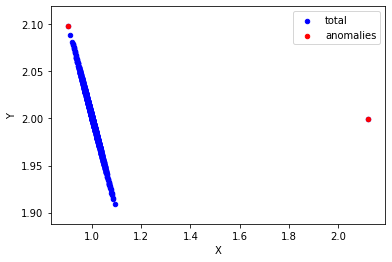

In [126]:
# the algorithm is quite stable, plot the results
import matplotlib.pyplot as plt
data_plot = data.plot(kind='scatter', x='X',y='Y',color = 'b',label ='total')
data.loc[(data.index == 188) | (data.index == 500)].plot(kind='scatter', x='X',y='Y',color = 'r',label ='anomalies', ax=data_plot)
data_plot.set_xlabel("X")
data_plot.set_ylabel("Y")
plt.show()

In [127]:
from itertools import count
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
import collections


def nd_rolling_op_1(data, window_size):
    """
    Generate the moving window

    data: pandas.core.frame.DataFrame
    window_size: float

    yield: tuple
    """

    # calculate the moving window for each idx-th point
    for idx, row in data.iterrows():
        idx0 = idx if idx - window_size < 0 else idx - window_size
        idx0_end = idx0 + window_size
        window_np = data.iloc[idx0:idx0_end] # Extract the window
        try:
            window_np_cov_inv = np.linalg.inv(window_np.cov())
            window_np_mean = window_np.mean(axis = 0)
        
            yield {'idx': idx,
               'value': np.array(row),
               'window_avg': window_np_mean,
               'window_cov_inv': window_np_cov_inv}
        except np.linalg.LinAlgError as e: 
            pass

def distance_op_1(p):
    return mahalanobis(p['value'], p['window_avg'],p['window_cov_inv'])
    
    
def get_anomalous_values_op_1(data, window_size, prob=0.99):
    """
    return a list of anomalous values, i.e. the ones that exceed md times
    in terms of Mohalanobis distance the expected multivariate average. Both
    multivariate average and Mahalanobis distance are calculated considering
    the moving windows, i.e. the value computed considering window_size
    neighbours, moving the window for each value of the serie.

    data : pandas.core.frame.DataFrame
    window_size: int
    md: float

    return: list
    """

    # under normal hypotesis, the Mohalanobis dinstance is Chi-squared
    # distribuited
    threshold = np.sqrt(-2 * np.log(1 - prob))

    # calculate the moving window for each point, and report the anomaly if
    # the distance of the idx-th point is greater than md times the mahalanobis
    # distance
    return [(p['idx'], p['value']) for p in nd_rolling_op_1(data, window_size)
            if distance_op_1(p) > threshold]

In [128]:
# there is a point in the 500-th row that is visibly anomalous, let's see if the algorithm is able to detect it
print(get_anomalous_values_op_1(data, 500))

[(188, array([0.90166126, 2.09833874])), (500, array([2.12300124, 1.99897321]))]


In [129]:
from itertools import count
import numpy as np
import pandas as pd
from scipy.spatial.distance import mahalanobis
import collections


def nd_rolling_op_2(data, window_size):
    """
    Generate the moving window

    data: pandas.core.frame.DataFrame
    window_size: float

    yield: tuple
    """

    # calculate the moving window for each idx-th point
    for idx, row in data.iterrows():
        try:
            if idx % window_size == 0:
                idx0 = idx if idx - window_size < 0 else idx - window_size
                idx0_end = idx0 + window_size
                window_np = data.iloc[idx0:idx0_end] # Extract the window
                window_np_cov_inv = np.linalg.inv(window_np.cov())
                window_np_mean = window_np.mean(axis = 0)
            yield {'idx': idx,
                   'value': np.array(row),
                   'window_avg': window_np_mean,
                   'window_cov_inv': window_np_cov_inv}
        except np.linalg.LinAlgError as e: 
            pass

def distance_op_2(p):
    return mahalanobis(p['value'], p['window_avg'], p['window_cov_inv'])
    
    
def get_anomalous_values_op_2(data, window_size, prob=0.99):
    """
    return a list of anomalous values, i.e. the ones that exceed md times
    in terms of Mohalanobis distance the expected multivariate average. Both
    multivariate average and Mahalanobis distance are calculated considering
    the moving windows, i.e. the value computed considering window_size
    neighbours, moving the window for each value of the serie.

    data : pandas.core.frame.DataFrame
    window_size: int
    md: float

    return: list
    """

    # under normal hypotesis, the Mohalanobis dinstance is Chi-squared
    # distribuited
    threshold = np.sqrt(-2 * np.log(1 - prob))
    # calculate the moving window for each point, and report the anomaly if
    # the distance of the idx-th point is greater than md times the mahalanobis
    # distance
    return [(p['idx'], p['value']) for p in nd_rolling_op_2(data, window_size)
            if distance_op_2(p) > threshold]

In [130]:
# there is a point in the 500-th row that is visibly anomalous, let's see if the algorithm is able to detect it
print(get_anomalous_values_op_2(data, 500, 0.99))

[(188, array([0.90166126, 2.09833874])), (500, array([2.12300124, 1.99897321]))]


In [131]:
import json
# Export data in json
json.dumps(json.loads(data.to_json(orient='split'))["data"])

'[[0.9960426851, 2.0039573149], [0.9800163735, 2.0199836276], [0.9923345484, 2.0076654517], [1.0564898224, 1.9435101771], [0.9959860449, 2.0040139565], [1.029813744, 1.9701862563], [1.0073801894, 1.9926198107], [1.005554738, 1.9944452616], [1.0566139494, 1.9433860504], [0.9505240433, 2.0494759568], [1.0031183423, 1.9968816582], [0.9764026987, 2.0235973012], [0.9673641692, 2.0326358311], [1.0050313555, 1.9949686449], [0.9788905204, 2.0211094792], [1.050662272, 1.949337728], [0.9922922752, 2.0077077245], [1.0276944959, 1.9723055038], [1.0188549244, 1.981145076], [1.0384246228, 1.9615753775], [1.0448693158, 1.9551306838], [0.9789614194, 2.0210385817], [1.0347018559, 1.9652981429], [1.0001389604, 1.999861039], [0.9905581799, 2.0094418204], [1.0205728388, 1.9794271606], [1.0303929917, 1.9696070088], [1.0115519271, 1.9884480729], [1.023357992, 1.9766420079], [1.0786784895, 1.9213215111], [0.9878857605, 2.0121142389], [1.0410942648, 1.9589057345], [1.03730083, 1.9626991701], [0.9923889504, 2.

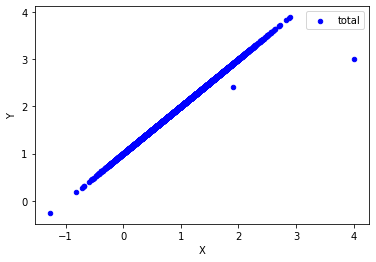

original:	data size=1002 time=0.4778780937194824s,	anomalous_values size= 6
optimization 1:	data size=1002 time=0.8408000469207764s,	anomalous_values size= 6
optimization 2:	data size=1002 time=0.06921076774597168s,	anomalous_values size= 2
original:	data size=2002 time=1.6584460735321045s,	anomalous_values size= 17
optimization 1:	data size=2002 time=1.5381829738616943s,	anomalous_values size= 17
optimization 2:	data size=2002 time=0.11831212043762207s,	anomalous_values size= 8
original:	data size=3002 time=3.1647307872772217s,	anomalous_values size= 7
optimization 1:	data size=3002 time=1.9314470291137695s,	anomalous_values size= 7
optimization 2:	data size=3002 time=0.1477518081665039s,	anomalous_values size= 8
original:	data size=4002 time=4.9801552295684814s,	anomalous_values size= 18
optimization 1:	data size=4002 time=2.6029140949249268s,	anomalous_values size= 19
optimization 2:	data size=4002 time=0.19490790367126465s,	anomalous_values size= 11
original:	data size=5002 time=7.

In [135]:
import numpy as np
import pandas as pd
import time
mu, sigma = 2, 0.10 # mean and standard deviation
sY =  np.random.normal(2, 0.5, 10000)
sX = sY - 1 

sX = np.append(sX, [4])
sY = np.append(sY, [3])
sX = np.append(sX, [1.9])
sY = np.append(sY, [2.4])

import matplotlib.pyplot as plt
data1 = pd.DataFrame({'X': sX, 'Y': sY})
data_plot = data1.plot(kind='scatter', x='X',y='Y',color = 'b',label ='total')
data_plot.set_xlabel("X")
data_plot.set_ylabel("Y")
plt.show()

result = []
for i in range(1000, 10003, 1000):
    mu, sigma = 2, 0.10 # mean and standard deviation
    sY =  np.random.normal(2, 0.5, i)
    sX = sY - 1 

    sX = np.append([4], sX)
    sY = np.append([3], sY)
    sX = np.append([1.9], sX)
    sY = np.append([2.4], sY)
    data1 = pd.DataFrame({'X': sX, 'Y': sY})

    t0 = time.time()
    data_original = get_anomalous_values_original(data1, int(len(sY)/2), prob=0.99)
    t1 = time.time()
    total = t1-t0
    print("original:\tdata size=" + str(len(sY))+" time=" + str(total) + "s,\tanomalous_values size=", len(data_original))
    result.append(['original', len(sY),  total])
    
    t0 = time.time()
    data_original = get_anomalous_values_op_1(data1, int(len(sY)/2), prob=0.99)
    t1 = time.time()
    total = t1-t0
    print("optimization 1:\tdata size=" + str(len(sY))+" time=" + str(total) + "s,\tanomalous_values size=", len(data_original))
    result.append(['optimization_1', len(sY),  total])
    
    t0 = time.time()
    data_original = get_anomalous_values_op_2(data1, int(len(sY)/2), prob=0.99)
    t1 = time.time()
    total = t1-t0
    print("optimization 2:\tdata size=" + str(len(sY))+" time=" + str(total) + "s,\tanomalous_values size=", len(data_original))
    result.append(['optimization_2', len(sY),  total])



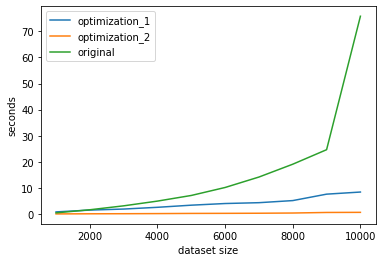

In [136]:
from pandas import DataFrame
#df = DataFrame.from_records(data)
df = pd.DataFrame(result,
                   columns=['version', 'dataset_size', 'time_in_seconds'])


fig, ax = plt.subplots()

group_data = df.groupby('version')
legend = []
for key, group in group_data:
    legend.append(key)
    group.plot(x='dataset_size', ax=ax,  label=key, legend=True)

plt.legend(legend)
plt.xlabel('dataset size')
plt.ylabel('seconds')

plt.show()